In [1]:
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir
from reviews.preprocess import preprocess

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Prepare Data

In [2]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)

reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53193 entries, 0 to 53192
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   asin         53193 non-null  object        
 1   overall      53193 non-null  int64         
 2   summary      53193 non-null  string        
 3   text         53193 non-null  string        
 4   timestamp    53193 non-null  datetime64[ns]
 5   vote         53193 non-null  int64         
 6   brand        53193 non-null  object        
 7   category     53193 non-null  object        
 8   description  53193 non-null  object        
 9   title        53193 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5), string(2)
memory usage: 4.5+ MB


In [3]:
from reviews.preprocess import STOPWORDS

STOPWORDS.difference_update({"star", "work"})

In [4]:
def flat_sentence_tokens(tokens):
    return [token for row in tokens for sent in row for token in sent]

In [5]:
def tokens_counters(tokens_raw, tokens_lemma, tokens_stem):
    # flat sentence tokens
    tokens_raw = flat_sentence_tokens(tokens_raw)
    tokens_lemma = flat_sentence_tokens(tokens_lemma)
    tokens_stem = flat_sentence_tokens(tokens_stem)

    # counters
    c_raw = Counter(tokens_raw)
    c_lemma = Counter(tokens_lemma)
    c_stem = Counter(tokens_stem)

    return {
        "Raw": c_raw,
        "Lemmatization": c_lemma,
        "Stemming": c_stem,
    }

In [6]:
def plot_tokens(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex="all")
    for i, (title, counter) in enumerate(counters_dict.items()):
        data = pd.DataFrame(counter.most_common(30))
        sns.barplot(y=data[0], x=data[1], ax=ax[i])
        ax[i].set_title(title)
        ax[i].set_ylabel("Tokens")
        ax[i].set_xlabel("Frequency")
    fig.tight_layout()

In [7]:
def plot_tokens_wordcloud(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    for i, (title, counter) in enumerate(counters_dict.items()):
        wc = WordCloud(
            collocations=False,
            prefer_horizontal=0.6,
            width=800,
            height=400,
            background_color="white",
        )
        wc.fit_words(counter)

        ax[i].imshow(wc.to_image())
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].axis("off")

    fig.tight_layout()

# Summary Tokens

In [8]:
summary_raw = reviews_df["summary"].parallel_apply(lambda x: preprocess(x))

In [9]:
summary_lemma = reviews_df["summary"].parallel_apply(
    lambda x: preprocess(x, lemmatization=True)
)

reviews_df["tokens"] = summary_lemma
reviews_df.to_json(processed_data_dir / f"reviews_summary_lemmatization.json.gz")

In [10]:
summary_stem = reviews_df["summary"].parallel_apply(
    lambda x: preprocess(x, stemming=True)
)

reviews_df["tokens"] = summary_stem
reviews_df.to_json(processed_data_dir / f"reviews_summary_stemming.json.gz")

In [11]:
summary_counters = tokens_counters(summary_raw, summary_lemma, summary_stem)

In [12]:
for (title, counter) in summary_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 9870
Lemmatization Tokens: 8398
Stemming Tokens: 7410


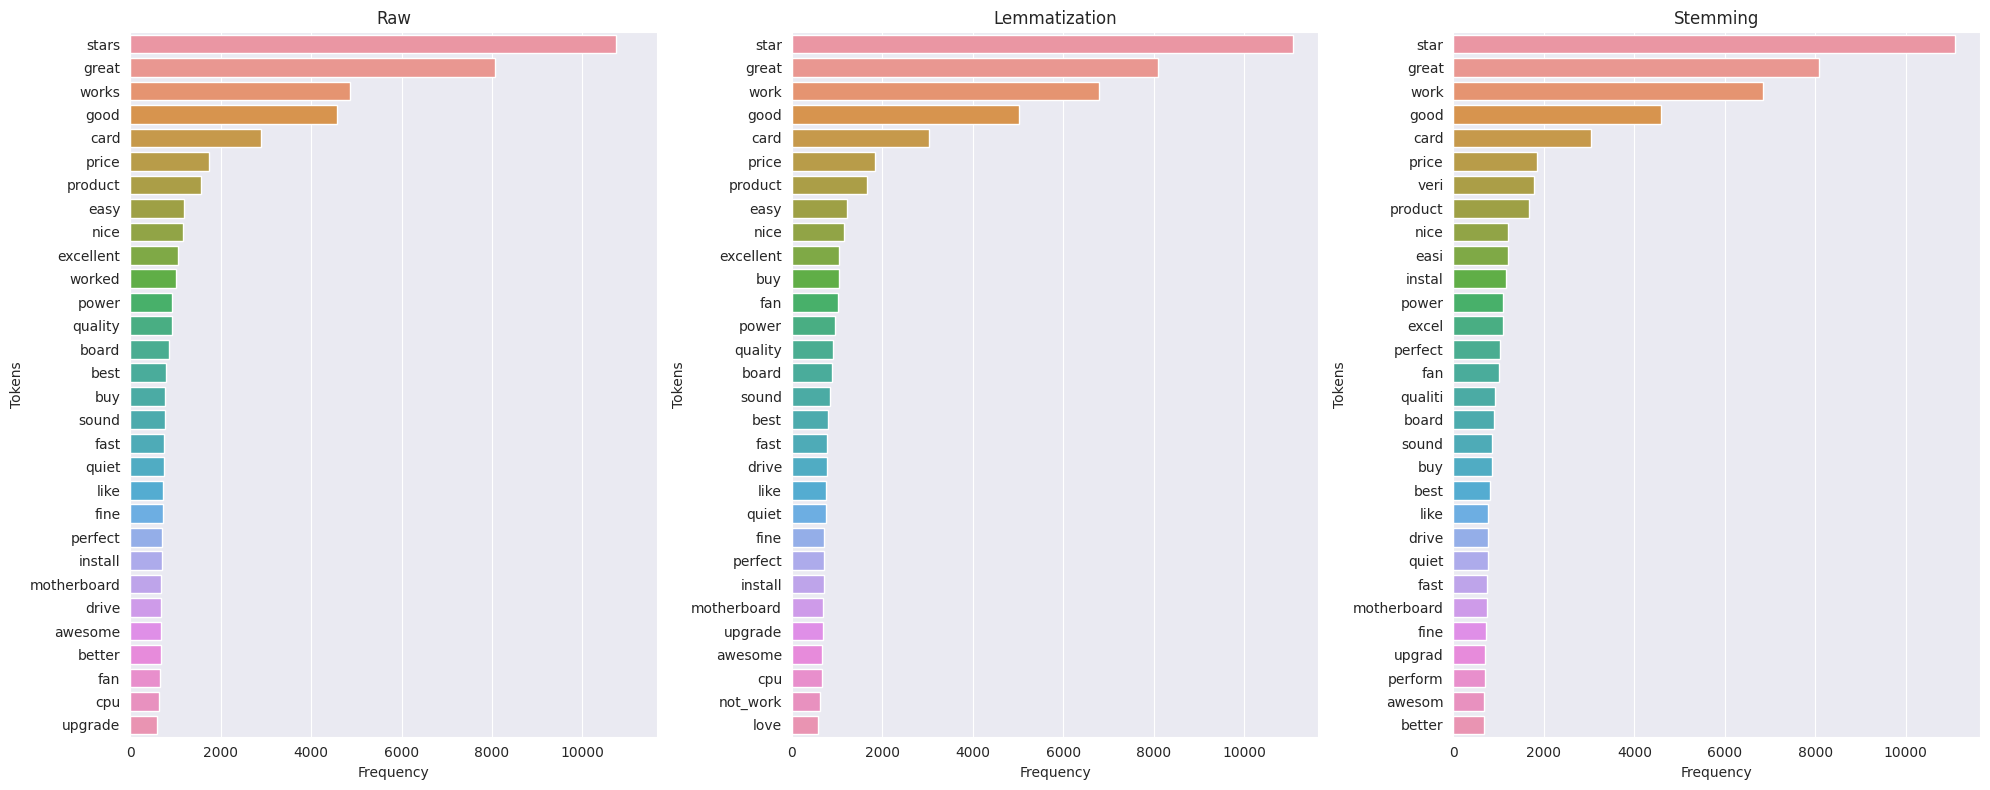

In [13]:
plot_tokens(summary_counters)

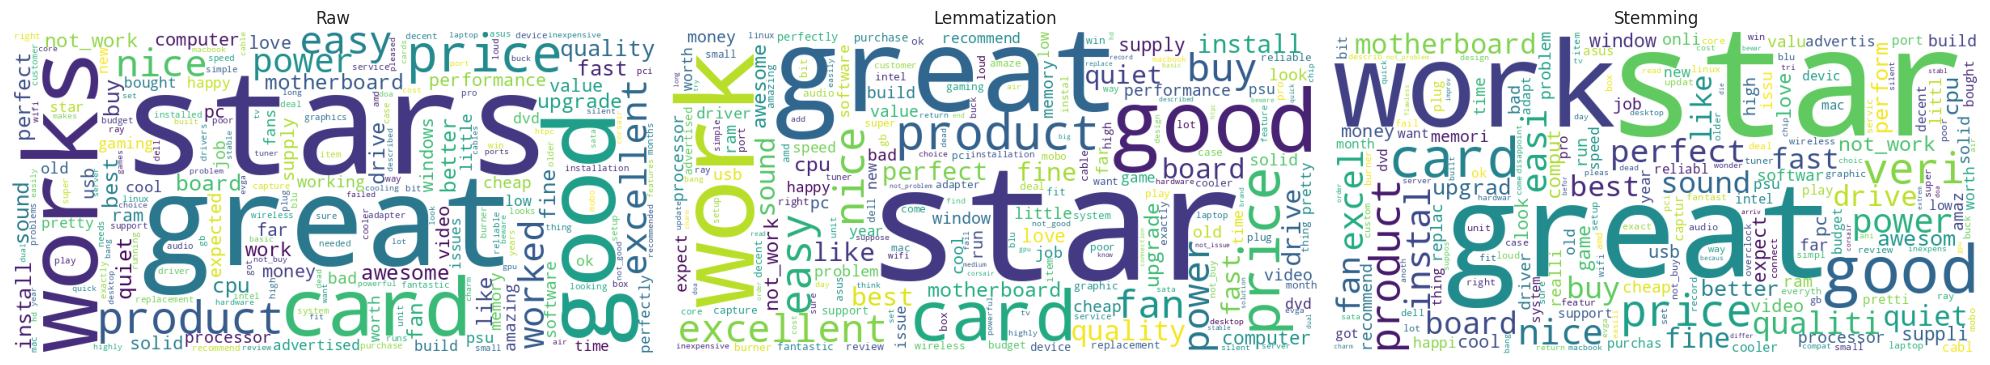

In [14]:
plot_tokens_wordcloud(summary_counters)

# Text Tokens

In [15]:
text_raw = reviews_df["text"].parallel_apply(lambda x: preprocess(x))

In [16]:
text_lemma = reviews_df["text"].parallel_apply(
    lambda x: preprocess(x, lemmatization=True)
)

reviews_df["tokens"] = text_lemma
reviews_df.to_json(processed_data_dir / f"reviews_summary_lemmatization.json.gz")

In [17]:
text_stem = reviews_df["text"].parallel_apply(lambda x: preprocess(x, stemming=True))

reviews_df["tokens"] = text_stem
reviews_df.to_json(processed_data_dir / f"reviews_text_stemming.json.gz")

In [18]:
text_counters = tokens_counters(text_raw, text_lemma, text_stem)

for (title, counter) in text_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 42066
Lemmatization Tokens: 35102
Stemming Tokens: 28313


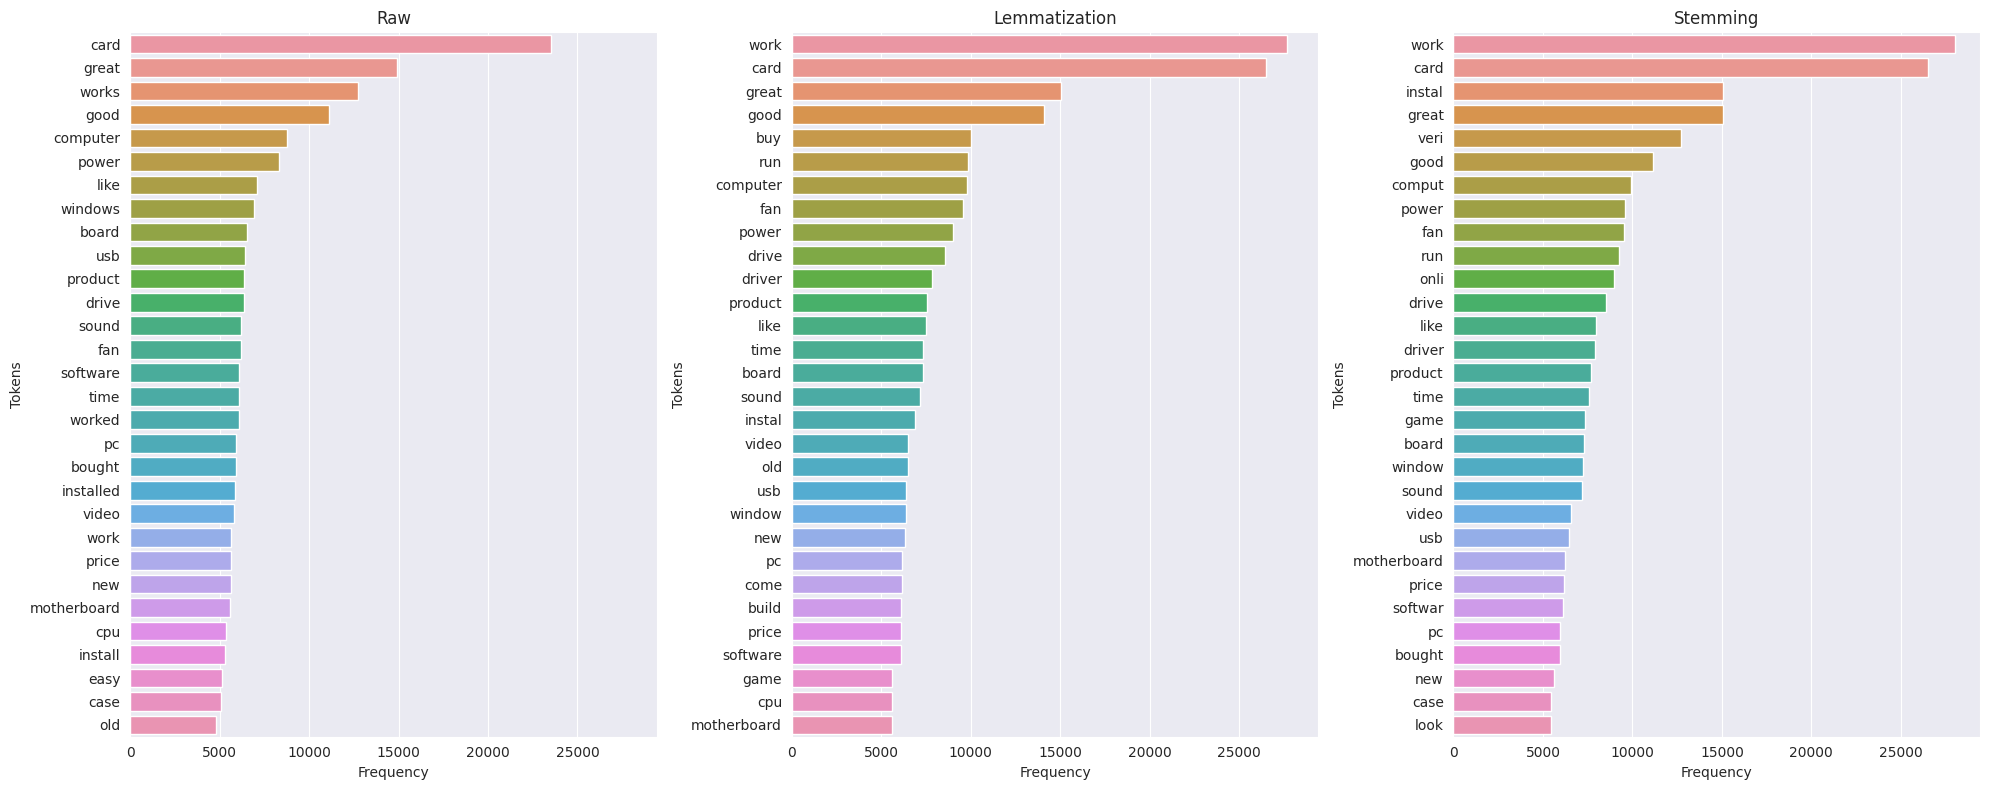

In [19]:
plot_tokens(text_counters)

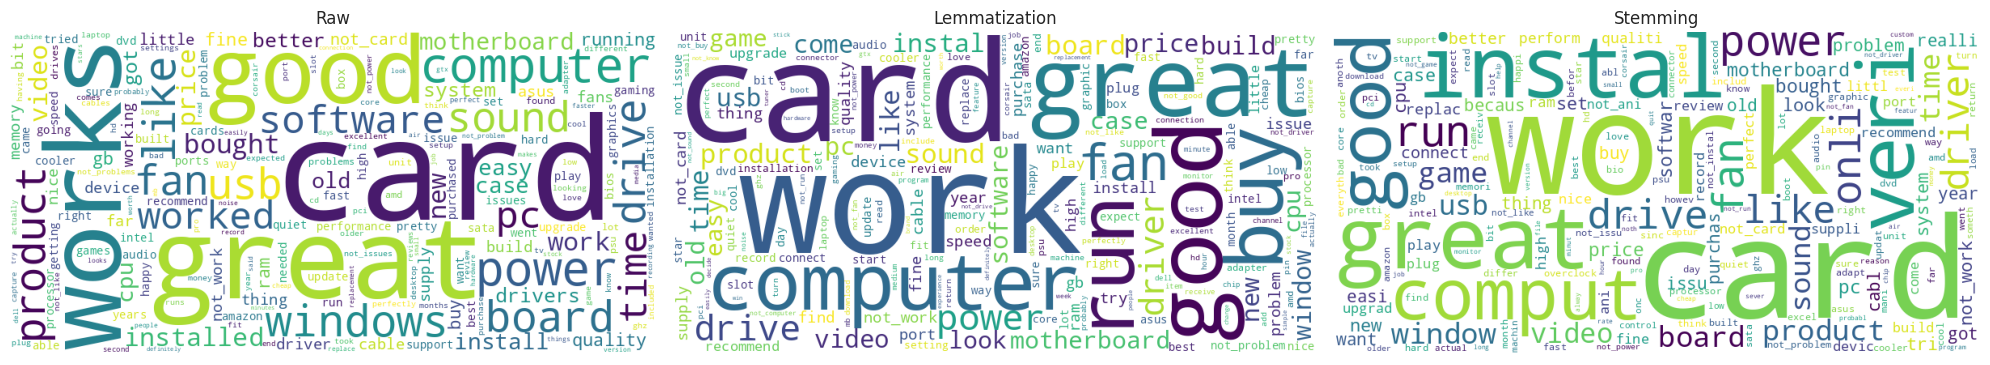

In [20]:
plot_tokens_wordcloud(text_counters)

# Polarity Analysis

In [21]:
# ground truth polarity
reviews_df["overall"] = reviews_df["overall"].parallel_apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)

In [22]:
positive_df = reviews_df[reviews_df["overall"] == "positive"]
positive_tokens = [
    word for doc in positive_df["tokens"] for sent in doc for word in sent
]
pos_c = Counter(positive_tokens)

print("positive tokens:", len(set(positive_tokens)))

negative_df = reviews_df[reviews_df["overall"] == "negative"]
negative_tokens = [
    word for doc in negative_df["tokens"] for sent in doc for word in sent
]
neg_c = Counter(negative_tokens)

print("negative tokens:", len(set(negative_tokens)))

positive tokens: 24531
negative tokens: 12722


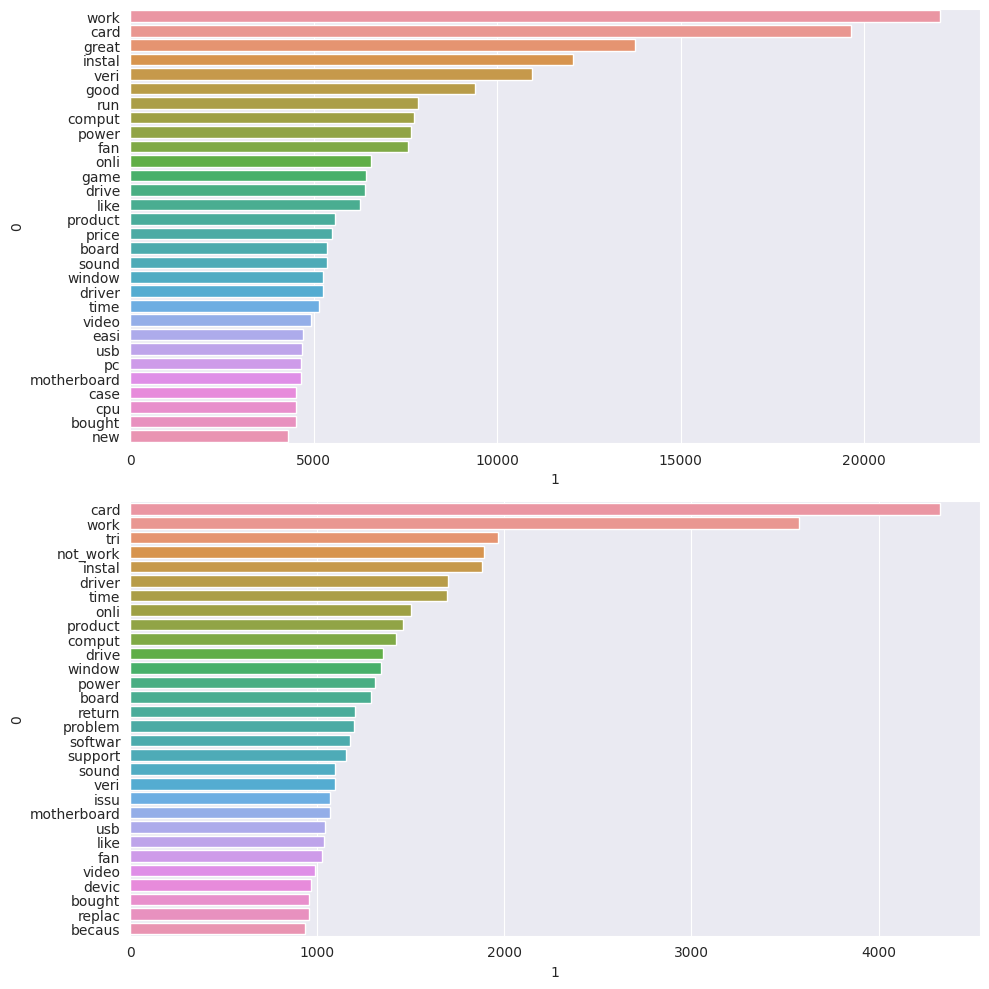

In [23]:
pos_data = pd.DataFrame(Counter(positive_tokens).most_common(30))
neg_data = pd.DataFrame(Counter(negative_tokens).most_common(30))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(y=pos_data[0], x=pos_data[1], ax=ax[0])
sns.barplot(y=neg_data[0], x=neg_data[1], ax=ax[1])
fig.tight_layout()